In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
"""
v1 - No expand
v2 - Expand
"""

RUN_ID = "run_2026_01_06_wide_mlp_v2"
model_save_name = "pyramidal_mlp_v2"

In [4]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [5]:
BATCH_SIZE = 2048
num_workers = 0

TRAIN_PATH = Path("./dataset_bitmaps/bitboard_train.npz")
VAL_PATH = Path("./dataset_bitmaps/bitboard_val.npz")
TEST_PATH = Path("./dataset_bitmaps/bitboard_test.npz") 

train_dataloader = DataLoader(dataset=NPZChessDataset(TRAIN_PATH), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset(VAL_PATH), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset(TEST_PATH), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [6]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.024974582195281984


In [7]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 775]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [8]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [9]:
class PyramidalMLP_v2(nn.Module):
    def __init__(self, input_shape=775, output_shape=7):
        super().__init__()
        
        self.network = nn.Sequential(
            # Project up to capture complex feature interactions
            nn.Linear(input_shape, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(400, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        return self.network(x)

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [11]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [12]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   epochs: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), f"{model_save_name}.pth")
        else:
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Val Loss: {val_loss} | Val Acc: {val_acc}")

        # To plot results later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [13]:
from torchinfo import summary

model = PyramidalMLP_v2(input_shape=775,
                        output_shape=7).to(device)

summary(model, input_size=(2048, 775))

Layer (type:depth-idx)                   Output Shape              Param #
PyramidalMLP_v2                          [2048, 7]                 --
├─Sequential: 1-1                        [2048, 7]                 --
│    └─Linear: 2-1                       [2048, 1024]              794,624
│    └─BatchNorm1d: 2-2                  [2048, 1024]              2,048
│    └─ReLU: 2-3                         [2048, 1024]              --
│    └─Dropout: 2-4                      [2048, 1024]              --
│    └─Linear: 2-5                       [2048, 600]               615,000
│    └─BatchNorm1d: 2-6                  [2048, 600]               1,200
│    └─ReLU: 2-7                         [2048, 600]               --
│    └─Dropout: 2-8                      [2048, 600]               --
│    └─Linear: 2-9                       [2048, 400]               240,400
│    └─BatchNorm1d: 2-10                 [2048, 400]               800
│    └─ReLU: 2-11                        [2048, 400]           

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001)

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)


  1%|          | 1/100 [01:07<1:51:09, 67.37s/it]

Epoch 0: New Best Val Loss: 1.2398 (Saved)
Epoch: 0 | Train Loss: 1.3489727314313253 | Train Acc: 0.44415912918613704 | Val Loss: 1.239813245197205 | Val Acc: 0.4880037956880457


  2%|▏         | 2/100 [02:13<1:48:58, 66.71s/it]

Epoch 1: New Best Val Loss: 1.1717 (Saved)
Epoch: 1 | Train Loss: 1.2137187905841405 | Train Acc: 0.5036699944833852 | Val Loss: 1.1716558113439905 | Val Acc: 0.5175477783909039


  3%|▎         | 3/100 [03:16<1:45:00, 64.96s/it]

Epoch 2: New Best Val Loss: 1.1411 (Saved)
Epoch: 2 | Train Loss: 1.1583377001550463 | Train Acc: 0.5285186611662772 | Val Loss: 1.141062687891742 | Val Acc: 0.5314103901125441


  4%|▍         | 4/100 [04:30<1:49:39, 68.54s/it]

Epoch 3: New Best Val Loss: 1.1234 (Saved)
Epoch: 3 | Train Loss: 1.1234981536865234 | Train Acc: 0.5440680470372533 | Val Loss: 1.1233505789737246 | Val Acc: 0.5388795318311862


  5%|▌         | 5/100 [05:44<1:51:50, 70.63s/it]

Epoch 4: New Best Val Loss: 1.1186 (Saved)
Epoch: 4 | Train Loss: 1.0995496628549364 | Train Acc: 0.5545865354036864 | Val Loss: 1.1185857305754574 | Val Acc: 0.5413332555470601


  6%|▌         | 6/100 [06:57<1:51:38, 71.26s/it]

Epoch 5: New Best Val Loss: 1.1047 (Saved)
Epoch: 5 | Train Loss: 1.0813141831292046 | Train Acc: 0.562403287253375 | Val Loss: 1.1046887676870456 | Val Acc: 0.5471267825470573


  7%|▋         | 7/100 [08:07<1:50:08, 71.06s/it]

Epoch 6: New Best Val Loss: 1.0957 (Saved)
Epoch: 6 | Train Loss: 1.066432123237186 | Train Acc: 0.5689398713330738 | Val Loss: 1.0957468280206362 | Val Acc: 0.5516665445974036


  8%|▊         | 8/100 [09:19<1:49:03, 71.13s/it]

Epoch 7: New Best Val Loss: 1.0935 (Saved)
Epoch: 7 | Train Loss: 1.0549701974391936 | Train Acc: 0.5740991968457945 | Val Loss: 1.0935125698815433 | Val Acc: 0.5530929359698413


  9%|▉         | 9/100 [10:31<1:48:15, 71.38s/it]

Epoch 8: New Best Val Loss: 1.0882 (Saved)
Epoch: 8 | Train Loss: 1.0447800381713443 | Train Acc: 0.5783576534916927 | Val Loss: 1.0882181913779456 | Val Acc: 0.554724772822441


 10%|█         | 10/100 [11:41<1:46:36, 71.07s/it]

Epoch 9: New Best Val Loss: 1.0825 (Saved)
Epoch: 9 | Train Loss: 1.0358088077174292 | Train Acc: 0.5824004543094496 | Val Loss: 1.0824823593116863 | Val Acc: 0.5582033074602465


 11%|█         | 11/100 [12:55<1:46:39, 71.90s/it]

Epoch 10: Train Loss: 1.0281 | Val Loss: 1.0832
Epoch: 10 | Train Loss: 1.0280790571901532 | Train Acc: 0.5857466032255971 | Val Loss: 1.083231907045475 | Val Acc: 0.5568889514365599


 12%|█▏        | 12/100 [14:18<1:50:33, 75.38s/it]

Epoch 11: New Best Val Loss: 1.0807 (Saved)
Epoch: 11 | Train Loss: 1.021037248240577 | Train Acc: 0.5890355351116303 | Val Loss: 1.0806556140603465 | Val Acc: 0.5583598524749579


 13%|█▎        | 13/100 [15:45<1:54:15, 78.79s/it]

Epoch 12: New Best Val Loss: 1.0797 (Saved)
Epoch: 12 | Train Loss: 1.0152554148038229 | Train Acc: 0.5910795516127986 | Val Loss: 1.079655565092588 | Val Acc: 0.5596303256899728


 14%|█▍        | 14/100 [17:06<1:53:51, 79.44s/it]

Epoch 13: New Best Val Loss: 1.0776 (Saved)
Epoch: 13 | Train Loss: 1.0096522685951657 | Train Acc: 0.5935159920982607 | Val Loss: 1.0776279969426958 | Val Acc: 0.5604662762644249


 15%|█▌        | 15/100 [18:31<1:55:13, 81.33s/it]

Epoch 14: New Best Val Loss: 1.0723 (Saved)
Epoch: 14 | Train Loss: 1.004552486790551 | Train Acc: 0.5956801085475077 | Val Loss: 1.072294840226808 | Val Acc: 0.562433852563703


 16%|█▌        | 16/100 [19:58<1:55:50, 82.75s/it]

Epoch 15: New Best Val Loss: 1.0714 (Saved)
Epoch: 15 | Train Loss: 0.9997512154844073 | Train Acc: 0.5980715034397716 | Val Loss: 1.0714057364561451 | Val Acc: 0.5647438706454014


 17%|█▋        | 17/100 [21:23<1:55:34, 83.55s/it]

Epoch 16: Train Loss: 0.9959 | Val Loss: 1.0748
Epoch: 16 | Train Loss: 0.9959127323362562 | Train Acc: 0.5997151597384476 | Val Loss: 1.0748417784329567 | Val Acc: 0.5615724373111368


 18%|█▊        | 18/100 [22:39<1:51:15, 81.41s/it]

Epoch 17: Train Loss: 0.9917 | Val Loss: 1.0722
Epoch: 17 | Train Loss: 0.9917492158677843 | Train Acc: 0.6014388215537383 | Val Loss: 1.0722252582120406 | Val Acc: 0.564012177072229


 19%|█▉        | 19/100 [23:58<1:48:58, 80.72s/it]

Epoch 18: Train Loss: 0.9885 | Val Loss: 1.0719
Epoch: 18 | Train Loss: 0.98849382686615 | Train Acc: 0.6030087677667445 | Val Loss: 1.0719294067942648 | Val Acc: 0.563192934763141


 20%|██        | 20/100 [25:20<1:48:08, 81.10s/it]

Epoch 19: New Best Val Loss: 1.0680 (Saved)
Epoch: 19 | Train Loss: 0.985001648982366 | Train Acc: 0.6045237977024922 | Val Loss: 1.0679974568174968 | Val Acc: 0.5658554369369926


 21%|██        | 21/100 [26:38<1:45:21, 80.02s/it]

Epoch 20: Train Loss: 0.9813 | Val Loss: 1.0709
Epoch: 20 | Train Loss: 0.9812682572470771 | Train Acc: 0.6058467821099429 | Val Loss: 1.0709427178109465 | Val Acc: 0.5635452523463268


 22%|██▏       | 22/100 [27:58<1:43:51, 79.89s/it]

Epoch 21: Train Loss: 0.9785 | Val Loss: 1.0691
Epoch: 21 | Train Loss: 0.9785267197026147 | Train Acc: 0.6072406554225078 | Val Loss: 1.0690691186299504 | Val Acc: 0.5653076909971473


 23%|██▎       | 23/100 [29:24<1:45:03, 81.86s/it]

Epoch 22: New Best Val Loss: 1.0660 (Saved)
Epoch: 22 | Train Loss: 0.9758064859443241 | Train Acc: 0.6086192513629284 | Val Loss: 1.0659521036994335 | Val Acc: 0.5662521228634017


 24%|██▍       | 24/100 [30:47<1:43:57, 82.07s/it]

Epoch 23: Train Loss: 0.9732 | Val Loss: 1.0665
Epoch: 23 | Train Loss: 0.9732235995133718 | Train Acc: 0.6094380751882139 | Val Loss: 1.0665082003883128 | Val Acc: 0.5667833270468502


 25%|██▌       | 25/100 [32:12<1:43:53, 83.11s/it]

Epoch 24: Train Loss: 0.9706 | Val Loss: 1.0680
Epoch: 24 | Train Loss: 0.9706137198607127 | Train Acc: 0.6108881149402907 | Val Loss: 1.0679810179378393 | Val Acc: 0.5654845599005124


 26%|██▌       | 26/100 [33:34<1:41:55, 82.64s/it]

Epoch 25: New Best Val Loss: 1.0639 (Saved)
Epoch: 25 | Train Loss: 0.9679250428411695 | Train Acc: 0.6119831228095794 | Val Loss: 1.0639261798647077 | Val Acc: 0.5671380429188588


 27%|██▋       | 27/100 [34:55<1:40:05, 82.27s/it]

Epoch 26: Train Loss: 0.9661 | Val Loss: 1.0640
Epoch: 26 | Train Loss: 0.9661345695124732 | Train Acc: 0.6124276232314382 | Val Loss: 1.0640235120119088 | Val Acc: 0.5686774547015013


 28%|██▊       | 28/100 [36:09<1:35:41, 79.74s/it]

Epoch 27: New Best Val Loss: 1.0596 (Saved)
Epoch: 27 | Train Loss: 0.9635352030595143 | Train Acc: 0.6137004214531412 | Val Loss: 1.0596014552148942 | Val Acc: 0.5694630230206175


 29%|██▉       | 29/100 [37:28<1:34:12, 79.61s/it]

Epoch 28: Train Loss: 0.9619 | Val Loss: 1.0620
Epoch: 28 | Train Loss: 0.9618910539944967 | Train Acc: 0.6142907973942109 | Val Loss: 1.0620143909910027 | Val Acc: 0.5688468824730344


 30%|███       | 30/100 [38:47<1:32:29, 79.27s/it]

Epoch 29: Train Loss: 0.9598 | Val Loss: 1.0661
Epoch: 29 | Train Loss: 0.9598387998739878 | Train Acc: 0.6151986459955867 | Val Loss: 1.066087028068894 | Val Acc: 0.5677477749700541


 31%|███       | 31/100 [40:13<1:33:28, 81.28s/it]

Epoch 30: New Best Val Loss: 1.0594 (Saved)
Epoch: 30 | Train Loss: 0.957998289876514 | Train Acc: 0.6161748138142523 | Val Loss: 1.0593558759412667 | Val Acc: 0.5711992400071784


 32%|███▏      | 32/100 [41:39<1:33:53, 82.85s/it]

Epoch 31: New Best Val Loss: 1.0579 (Saved)
Epoch: 31 | Train Loss: 0.9567611289289263 | Train Acc: 0.6168709197332554 | Val Loss: 1.057933976218969 | Val Acc: 0.5710216141176679


 33%|███▎      | 33/100 [43:04<1:33:10, 83.44s/it]

Epoch 32: Train Loss: 0.9549 | Val Loss: 1.0629
Epoch: 32 | Train Loss: 0.9548641509479947 | Train Acc: 0.6176236171956127 | Val Loss: 1.0629454987447824 | Val Acc: 0.5678064462936436


 34%|███▍      | 34/100 [44:32<1:33:24, 84.92s/it]

Epoch 33: New Best Val Loss: 1.0563 (Saved)
Epoch: 33 | Train Loss: 0.9531665898164113 | Train Acc: 0.618382024759865 | Val Loss: 1.0562552366240439 | Val Acc: 0.5720765015963368


 35%|███▌      | 35/100 [45:54<1:31:02, 84.04s/it]

Epoch 34: Train Loss: 0.9521 | Val Loss: 1.0602
Epoch: 34 | Train Loss: 0.9520898043844435 | Train Acc: 0.6188397678965473 | Val Loss: 1.0602013078159034 | Val Acc: 0.5702613691539289


 36%|███▌      | 36/100 [47:21<1:30:37, 84.96s/it]

Epoch 35: New Best Val Loss: 1.0561 (Saved)
Epoch: 35 | Train Loss: 0.9502433626121944 | Train Acc: 0.6193893168321651 | Val Loss: 1.0561406866682268 | Val Acc: 0.5719553152505602


 37%|███▋      | 37/100 [48:50<1:30:20, 86.04s/it]

Epoch 36: New Best Val Loss: 1.0549 (Saved)
Epoch: 36 | Train Loss: 0.9489695314566294 | Train Acc: 0.6205079301336968 | Val Loss: 1.0549068487544921 | Val Acc: 0.5733823404764616


 38%|███▊      | 38/100 [50:19<1:29:44, 86.85s/it]

Epoch 37: Train Loss: 0.9475 | Val Loss: 1.0584
Epoch: 37 | Train Loss: 0.9475022455321418 | Train Acc: 0.6206687796112409 | Val Loss: 1.0583560517623563 | Val Acc: 0.5722484759756048


 39%|███▉      | 39/100 [51:44<1:27:54, 86.47s/it]

Epoch 38: New Best Val Loss: 1.0545 (Saved)
Epoch: 38 | Train Loss: 0.9464501181178623 | Train Acc: 0.6212467435747664 | Val Loss: 1.054467297251314 | Val Acc: 0.5723905333109276


 40%|████      | 40/100 [53:10<1:26:15, 86.25s/it]

Epoch 39: Train Loss: 0.9451 | Val Loss: 1.0545
Epoch: 39 | Train Loss: 0.9451466238763597 | Train Acc: 0.622050936201973 | Val Loss: 1.0544934889155444 | Val Acc: 0.5721955541087093


 41%|████      | 41/100 [54:18<1:19:26, 80.78s/it]

Epoch 40: Train Loss: 0.9445 | Val Loss: 1.0568
Epoch: 40 | Train Loss: 0.9444714033603668 | Train Acc: 0.6221234354718328 | Val Loss: 1.0568188498044584 | Val Acc: 0.5712685986878444


 42%|████▏     | 42/100 [55:22<1:13:06, 75.62s/it]

Epoch 41: New Best Val Loss: 1.0530 (Saved)
Epoch: 41 | Train Loss: 0.9432069463200039 | Train Acc: 0.6231435196002076 | Val Loss: 1.0530011133122363 | Val Acc: 0.5738645826281189


 43%|████▎     | 43/100 [56:23<1:07:43, 71.28s/it]

Epoch 42: New Best Val Loss: 1.0524 (Saved)
Epoch: 42 | Train Loss: 0.9417145215670267 | Train Acc: 0.6231618234034267 | Val Loss: 1.0524048015932987 | Val Acc: 0.5736648684145955


 44%|████▍     | 44/100 [57:24<1:03:40, 68.23s/it]

Epoch 43: Train Loss: 0.9408 | Val Loss: 1.0554
Epoch: 43 | Train Loss: 0.9407605850431654 | Train Acc: 0.6240906781379802 | Val Loss: 1.0554421367091937 | Val Acc: 0.5747178067588827


 45%|████▌     | 45/100 [58:25<1:00:39, 66.18s/it]

Epoch 44: Train Loss: 0.9393 | Val Loss: 1.0539
Epoch: 44 | Train Loss: 0.9392679340574477 | Train Acc: 0.6245906684027778 | Val Loss: 1.0539200893848015 | Val Acc: 0.5740188958629747


 46%|████▌     | 46/100 [59:26<58:12, 64.67s/it]  

Epoch 45: New Best Val Loss: 1.0517 (Saved)
Epoch: 45 | Train Loss: 0.9385892634921603 | Train Acc: 0.6250310062143043 | Val Loss: 1.051734202144089 | Val Acc: 0.5738071286389961


 47%|████▋     | 47/100 [1:00:28<56:11, 63.61s/it]

Epoch 46: Train Loss: 0.9377 | Val Loss: 1.0554
Epoch: 46 | Train Loss: 0.937724706252416 | Train Acc: 0.6253017413843458 | Val Loss: 1.0554312506226549 | Val Acc: 0.5724711950120787


 48%|████▊     | 48/100 [1:01:28<54:24, 62.78s/it]

Epoch 47: New Best Val Loss: 1.0492 (Saved)
Epoch: 47 | Train Loss: 0.9368716905381944 | Train Acc: 0.6255443000389408 | Val Loss: 1.0492206663401866 | Val Acc: 0.5759992317863928


 49%|████▉     | 49/100 [1:02:30<52:56, 62.28s/it]

Epoch 48: Train Loss: 0.9361 | Val Loss: 1.0512
Epoch: 48 | Train Loss: 0.9361413023206923 | Train Acc: 0.6257186437240395 | Val Loss: 1.0511773521582828 | Val Acc: 0.574438789501412


 50%|█████     | 50/100 [1:03:31<51:34, 61.89s/it]

Epoch 49: Train Loss: 0.9348 | Val Loss: 1.0518
Epoch: 49 | Train Loss: 0.9347866728835635 | Train Acc: 0.6261683593749999 | Val Loss: 1.0518234315178907 | Val Acc: 0.5758519539052134


 51%|█████     | 51/100 [1:04:31<50:15, 61.54s/it]

Epoch 50: Train Loss: 0.9341 | Val Loss: 1.0534
Epoch: 50 | Train Loss: 0.934068988137775 | Train Acc: 0.6264949888045171 | Val Loss: 1.0534406054141985 | Val Acc: 0.573816457338869


 52%|█████▏    | 52/100 [1:05:33<49:11, 61.49s/it]

Epoch 51: New Best Val Loss: 1.0489 (Saved)
Epoch: 51 | Train Loss: 0.9334228868749407 | Train Acc: 0.6272277818341121 | Val Loss: 1.0488582509776432 | Val Acc: 0.57707550097539


 53%|█████▎    | 53/100 [1:06:34<48:07, 61.44s/it]

Epoch 52: New Best Val Loss: 1.0479 (Saved)
Epoch: 52 | Train Loss: 0.9320100485218896 | Train Acc: 0.6275475130613967 | Val Loss: 1.0478984939360374 | Val Acc: 0.5764937116475278


 54%|█████▍    | 54/100 [1:07:35<46:55, 61.20s/it]

Epoch 53: New Best Val Loss: 1.0476 (Saved)
Epoch: 53 | Train Loss: 0.9318713039822049 | Train Acc: 0.6279094500421859 | Val Loss: 1.0476415690301628 | Val Acc: 0.5765520205692473


 55%|█████▌    | 55/100 [1:08:38<46:29, 61.98s/it]

Epoch 54: Train Loss: 0.9315 | Val Loss: 1.0482
Epoch: 54 | Train Loss: 0.931513642999861 | Train Acc: 0.6279147614064122 | Val Loss: 1.048153851829698 | Val Acc: 0.5763009096549992


 56%|█████▌    | 56/100 [1:09:42<45:45, 62.39s/it]

Epoch 55: New Best Val Loss: 1.0471 (Saved)
Epoch: 55 | Train Loss: 0.9306925479306115 | Train Acc: 0.6283794932015836 | Val Loss: 1.0471076674428816 | Val Acc: 0.5767928499045744


 57%|█████▋    | 57/100 [1:10:44<44:41, 62.35s/it]

Epoch 56: Train Loss: 0.9295 | Val Loss: 1.0487
Epoch: 56 | Train Loss: 0.9294956823190054 | Train Acc: 0.6287881932275442 | Val Loss: 1.048693440879978 | Val Acc: 0.5762657538751422


 58%|█████▊    | 58/100 [1:11:46<43:36, 62.29s/it]

Epoch 57: New Best Val Loss: 1.0463 (Saved)
Epoch: 57 | Train Loss: 0.9290687004460229 | Train Acc: 0.6289409336870457 | Val Loss: 1.0463474763131386 | Val Acc: 0.5769288499514992


 59%|█████▉    | 59/100 [1:12:48<42:31, 62.24s/it]

Epoch 58: Train Loss: 0.9289 | Val Loss: 1.0473
Epoch: 58 | Train Loss: 0.9288904232449001 | Train Acc: 0.6290924957814122 | Val Loss: 1.047279241752299 | Val Acc: 0.5770274190624256


 60%|██████    | 60/100 [1:13:50<41:25, 62.14s/it]

Epoch 59: Train Loss: 0.9278 | Val Loss: 1.0505
Epoch: 59 | Train Loss: 0.9278477415773604 | Train Acc: 0.6295689394308152 | Val Loss: 1.050453374410245 | Val Acc: 0.5769149709393439


 61%|██████    | 61/100 [1:14:53<40:27, 62.24s/it]

Epoch 60: New Best Val Loss: 1.0456 (Saved)
Epoch: 60 | Train Loss: 0.9274515710936653 | Train Acc: 0.629745306009865 | Val Loss: 1.0456123919617193 | Val Acc: 0.5778355430500511


 62%|██████▏   | 62/100 [1:15:55<39:26, 62.29s/it]

Epoch 61: Train Loss: 0.9262 | Val Loss: 1.0462
Epoch: 61 | Train Loss: 0.9262465060551961 | Train Acc: 0.6299259341738058 | Val Loss: 1.0462187180746945 | Val Acc: 0.5792129975769279


 63%|██████▎   | 63/100 [1:16:57<38:22, 62.24s/it]

Epoch 62: New Best Val Loss: 1.0456 (Saved)
Epoch: 62 | Train Loss: 0.9263176192972395 | Train Acc: 0.6303440943827882 | Val Loss: 1.0455755070614734 | Val Acc: 0.5777737416377238


 64%|██████▍   | 64/100 [1:17:59<37:16, 62.13s/it]

Epoch 63: Train Loss: 0.9255 | Val Loss: 1.0469
Epoch: 63 | Train Loss: 0.9254644119474623 | Train Acc: 0.6303829350012979 | Val Loss: 1.046895783305575 | Val Acc: 0.5773213297774406


 65%|██████▌   | 65/100 [1:19:01<36:16, 62.19s/it]

Epoch 64: New Best Val Loss: 1.0448 (Saved)
Epoch: 64 | Train Loss: 0.925204915523529 | Train Acc: 0.6303435062143043 | Val Loss: 1.044769888444972 | Val Acc: 0.5790611441972358


 66%|██████▌   | 66/100 [1:20:04<35:13, 62.16s/it]

Epoch 65: New Best Val Loss: 1.0443 (Saved)
Epoch: 65 | Train Loss: 0.9248366373115116 | Train Acc: 0.6307856401706906 | Val Loss: 1.0442515756083024 | Val Acc: 0.5776572287369112


 67%|██████▋   | 67/100 [1:21:06<34:12, 62.18s/it]

Epoch 66: Train Loss: 0.9239 | Val Loss: 1.0459
Epoch: 66 | Train Loss: 0.923923931201299 | Train Acc: 0.6314443872501297 | Val Loss: 1.045852056745783 | Val Acc: 0.5783719495893009


 68%|██████▊   | 68/100 [1:22:08<33:08, 62.15s/it]

Epoch 67: Train Loss: 0.9239 | Val Loss: 1.0452
Epoch: 67 | Train Loss: 0.923888822529051 | Train Acc: 0.6311923290660696 | Val Loss: 1.0452159519081636 | Val Acc: 0.5776824289596068


 69%|██████▉   | 69/100 [1:23:10<32:07, 62.18s/it]

Epoch 68: New Best Val Loss: 1.0431 (Saved)
Epoch: 68 | Train Loss: 0.9230533613098992 | Train Acc: 0.631623773364486 | Val Loss: 1.0431429306394817 | Val Acc: 0.5791670061210823


 70%|███████   | 70/100 [1:24:12<31:06, 62.20s/it]

Epoch 69: New Best Val Loss: 1.0407 (Saved)
Epoch: 69 | Train Loss: 0.9223864234553443 | Train Acc: 0.6319031850337488 | Val Loss: 1.040657572168539 | Val Acc: 0.5792797802659235


 71%|███████   | 71/100 [1:25:14<30:01, 62.12s/it]

Epoch 70: Train Loss: 0.9218 | Val Loss: 1.0435
Epoch: 70 | Train Loss: 0.9217907770739662 | Train Acc: 0.6320350057599948 | Val Loss: 1.043520499821816 | Val Acc: 0.5784928099133182


 72%|███████▏  | 72/100 [1:26:16<28:59, 62.11s/it]

Epoch 71: Train Loss: 0.9216 | Val Loss: 1.0470
Epoch: 71 | Train Loss: 0.9215920370154911 | Train Acc: 0.6322771863642264 | Val Loss: 1.0470133883554373 | Val Acc: 0.5766358123591362


 73%|███████▎  | 73/100 [1:27:18<27:56, 62.10s/it]

Epoch 72: Train Loss: 0.9209 | Val Loss: 1.0436
Epoch: 72 | Train Loss: 0.9209464598496755 | Train Acc: 0.6326036008080218 | Val Loss: 1.0435793568656713 | Val Acc: 0.5794371620231765


 74%|███████▍  | 74/100 [1:28:21<26:55, 62.14s/it]

Epoch 73: New Best Val Loss: 1.0389 (Saved)
Epoch: 73 | Train Loss: 0.9205709410508474 | Train Acc: 0.6327975130613966 | Val Loss: 1.0388744200862716 | Val Acc: 0.5819688231296191


 75%|███████▌  | 75/100 [1:29:23<25:52, 62.11s/it]

Epoch 74: Train Loss: 0.9201 | Val Loss: 1.0442
Epoch: 74 | Train Loss: 0.9200549643569522 | Train Acc: 0.6329948139765057 | Val Loss: 1.0442370391949858 | Val Acc: 0.5796438248378051


 76%|███████▌  | 76/100 [1:30:25<24:52, 62.20s/it]

Epoch 75: Train Loss: 0.9196 | Val Loss: 1.0468
Epoch: 75 | Train Loss: 0.9195843358569675 | Train Acc: 0.6332352909203012 | Val Loss: 1.046784147060772 | Val Acc: 0.5784411487571748


 77%|███████▋  | 77/100 [1:31:29<23:59, 62.61s/it]

Epoch 76: Train Loss: 0.9193 | Val Loss: 1.0396
Epoch: 76 | Train Loss: 0.9193009704218971 | Train Acc: 0.6332459059417186 | Val Loss: 1.039630434618875 | Val Acc: 0.5802402067876823


 78%|███████▊  | 78/100 [1:32:31<22:56, 62.56s/it]

Epoch 77: New Best Val Loss: 1.0388 (Saved)
Epoch: 77 | Train Loss: 0.9187469463878207 | Train Acc: 0.6334684571326583 | Val Loss: 1.0388089727623064 | Val Acc: 0.5808454067166504


 79%|███████▉  | 79/100 [1:33:33<21:50, 62.43s/it]

Epoch 78: Train Loss: 0.9183 | Val Loss: 1.0435
Epoch: 78 | Train Loss: 0.9182719618479411 | Train Acc: 0.6337010144892264 | Val Loss: 1.043485034447888 | Val Acc: 0.5791540002315789


 80%|████████  | 80/100 [1:34:35<20:46, 62.32s/it]

Epoch 79: Train Loss: 0.9184 | Val Loss: 1.0416
Epoch: 79 | Train Loss: 0.9183785786363814 | Train Acc: 0.633755914135514 | Val Loss: 1.041575953822087 | Val Acc: 0.5792774617334968


 81%|████████  | 81/100 [1:35:38<19:45, 62.40s/it]

Epoch 80: Train Loss: 0.9180 | Val Loss: 1.0391
Epoch: 80 | Train Loss: 0.9180083405706617 | Train Acc: 0.6339280787577881 | Val Loss: 1.039119106917658 | Val Acc: 0.5806571732264595


 82%|████████▏ | 82/100 [1:36:40<18:40, 62.26s/it]

Epoch 81: Train Loss: 0.9174 | Val Loss: 1.0433
Epoch: 81 | Train Loss: 0.9173681622081332 | Train Acc: 0.6339073338525442 | Val Loss: 1.043318562540178 | Val Acc: 0.578833972794931


 83%|████████▎ | 83/100 [1:37:42<17:37, 62.22s/it]

Epoch 82: Train Loss: 0.9170 | Val Loss: 1.0417
Epoch: 82 | Train Loss: 0.9169900286197662 | Train Acc: 0.6343634479653426 | Val Loss: 1.0417009250295854 | Val Acc: 0.5791236774094782


 84%|████████▍ | 84/100 [1:38:44<16:35, 62.19s/it]

Epoch 83: Train Loss: 0.9168 | Val Loss: 1.0435
Epoch: 83 | Train Loss: 0.9168357144726648 | Train Acc: 0.6341883343879803 | Val Loss: 1.043546690672331 | Val Acc: 0.5790075520967659


 85%|████████▌ | 85/100 [1:39:46<15:33, 62.21s/it]

Epoch 84: Train Loss: 0.9159 | Val Loss: 1.0432
Epoch: 84 | Train Loss: 0.9158696788416969 | Train Acc: 0.6348834740881361 | Val Loss: 1.0432470359493033 | Val Acc: 0.5784272879350748


 86%|████████▌ | 86/100 [1:40:49<14:32, 62.32s/it]

Epoch 85: Train Loss: 0.9160 | Val Loss: 1.0402
Epoch: 85 | Train Loss: 0.9160057949754927 | Train Acc: 0.6348322166244807 | Val Loss: 1.0401841448842462 | Val Acc: 0.5806758306262053


 87%|████████▋ | 87/100 [1:41:51<13:29, 62.27s/it]

Epoch 86: Train Loss: 0.9156 | Val Loss: 1.0403
Epoch: 86 | Train Loss: 0.9156066747771369 | Train Acc: 0.6349283586448599 | Val Loss: 1.0402720767890228 | Val Acc: 0.5804425403691617


 88%|████████▊ | 88/100 [1:42:53<12:26, 62.21s/it]

Epoch 87: New Best Val Loss: 1.0378 (Saved)
Epoch: 87 | Train Loss: 0.9152218187120226 | Train Acc: 0.6350127721800364 | Val Loss: 1.0377772023246556 | Val Acc: 0.5816130676259911


 89%|████████▉ | 89/100 [1:43:55<11:23, 62.11s/it]

Epoch 88: New Best Val Loss: 1.0363 (Saved)
Epoch: 88 | Train Loss: 0.9150218402014838 | Train Acc: 0.6351083122403945 | Val Loss: 1.0362510801175349 | Val Acc: 0.5806814387601622


 90%|█████████ | 90/100 [1:44:57<10:21, 62.13s/it]

Epoch 89: Train Loss: 0.9144 | Val Loss: 1.0389
Epoch: 89 | Train Loss: 0.9144222854508294 | Train Acc: 0.6354952175817756 | Val Loss: 1.0389227781686359 | Val Acc: 0.5819211036185247


 91%|█████████ | 91/100 [1:45:59<09:19, 62.14s/it]

Epoch 90: Train Loss: 0.9140 | Val Loss: 1.0367
Epoch: 90 | Train Loss: 0.9139929265975952 | Train Acc: 0.6358021754121236 | Val Loss: 1.0366782208351553 | Val Acc: 0.583000521086315


 92%|█████████▏| 92/100 [1:47:02<08:17, 62.20s/it]

Epoch 91: Train Loss: 0.9137 | Val Loss: 1.0371
Epoch: 91 | Train Loss: 0.9136942468219333 | Train Acc: 0.6357187978647456 | Val Loss: 1.0371197970653963 | Val Acc: 0.5813943881810177


 93%|█████████▎| 93/100 [1:48:04<07:15, 62.18s/it]

Epoch 92: Train Loss: 0.9133 | Val Loss: 1.0420
Epoch: 92 | Train Loss: 0.9133285361660851 | Train Acc: 0.6357371832002856 | Val Loss: 1.0420153962874168 | Val Acc: 0.5795576347590934


 94%|█████████▍| 94/100 [1:49:06<06:13, 62.26s/it]

Epoch 93: Train Loss: 0.9135 | Val Loss: 1.0387
Epoch: 93 | Train Loss: 0.9135371669928233 | Train Acc: 0.6357826607930945 | Val Loss: 1.03872933688831 | Val Acc: 0.5817397207829877


 95%|█████████▌| 95/100 [1:50:08<05:11, 62.24s/it]

Epoch 94: New Best Val Loss: 1.0340 (Saved)
Epoch: 94 | Train Loss: 0.9126793885495927 | Train Acc: 0.6363803730205089 | Val Loss: 1.0340408131531074 | Val Acc: 0.5829725349866963


 96%|█████████▌| 96/100 [1:51:11<04:09, 62.31s/it]

Epoch 95: Train Loss: 0.9131 | Val Loss: 1.0371
Epoch: 95 | Train Loss: 0.9131466913223266 | Train Acc: 0.6360116615556853 | Val Loss: 1.0371161965786801 | Val Acc: 0.5825289481016791


 97%|█████████▋| 97/100 [1:52:14<03:07, 62.42s/it]

Epoch 96: Train Loss: 0.9122 | Val Loss: 1.0368
Epoch: 96 | Train Loss: 0.9121955997943878 | Train Acc: 0.63667300793419 | Val Loss: 1.036839565115984 | Val Acc: 0.5829045965295747


 98%|█████████▊| 98/100 [1:53:16<02:04, 62.44s/it]

Epoch 97: Train Loss: 0.9122 | Val Loss: 1.0376
Epoch: 97 | Train Loss: 0.9122419754929013 | Train Acc: 0.6364971520476377 | Val Loss: 1.0376385741266374 | Val Acc: 0.5825651001368698


 99%|█████████▉| 99/100 [1:54:18<01:02, 62.41s/it]

Epoch 98: Train Loss: 0.9116 | Val Loss: 1.0362
Epoch: 98 | Train Loss: 0.9115795432461633 | Train Acc: 0.6368116493866822 | Val Loss: 1.0361976409934894 | Val Acc: 0.5820389751765409


100%|██████████| 100/100 [1:55:21<00:00, 69.21s/it]

Epoch 99: Train Loss: 0.9111 | Val Loss: 1.0355
Epoch: 99 | Train Loss: 0.9110564124584198 | Train Acc: 0.6371430393302181 | Val Loss: 1.03552807048726 | Val Acc: 0.5817527448625462

Loaded best model weights with Val Loss: 1.0340


In [15]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [16]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Converts FEN to a 775-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(775, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0

    # Is there a check?
    vector[774] = 1.0 if board.is_check() else 0.0
    
    return vector

Model Prediction:  4
Stockfish Evaluation:  5


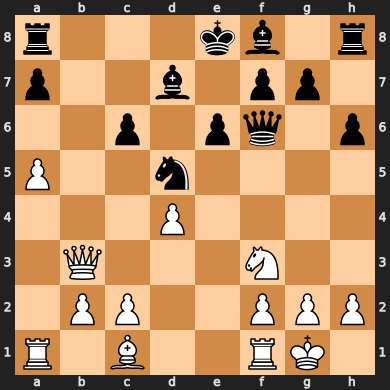

In [17]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [18]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.75      0.65      0.70     85601
           1       0.52      0.54      0.53     85601
           2       0.50      0.59      0.54     85601
           3       0.57      0.52      0.55     85601
           4       0.53      0.60      0.56     85601
           5       0.52      0.54      0.53     85601
           6       0.76      0.65      0.70     85601

    accuracy                           0.58    599207
   macro avg       0.59      0.58      0.59    599207
weighted avg       0.59      0.58      0.59    599207



In [19]:
import json
import time

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = "experiments/logs"):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = "experiments/logs"):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [20]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = "experiments/results"):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [21]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
    "input_shape": 775,
    "output_shape": 7
}

dataset_paths = {
    "train": str(TRAIN_PATH),
    "val":   str(VAL_PATH),
    "test":  str(TEST_PATH)
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/run_2026_01_06_wide_mlp_v2_config.json
[Logs] Saved training history to experiments/logs/run_2026_01_06_wide_mlp_v2_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        58.20%
[Results] Off-by-1 Acc:    86.64%
[Results] MAE:             0.6461
[Results] Latency:         0.0127 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 21939 samples
   - Off by 4: 8268 samples
   - Off by 5: 3812 samples
   - Off by 6: 1543 samples
[Results] Saved all metrics to experiments/results
------------------------------------------------------------


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(experiment_name: str, save_dir: str = "experiments/results"):
    matrix_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    try:
        cm = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Could not find matrix at {matrix_path}")
        return

    class_names = [
        "White Win", "White Decisive", "White Better", "Equal", 
        "Black Better", "Black Decisive", "Black Win"
    ]

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f"Confusion Matrix: {experiment_name}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.show()

# plot_confusion_matrix(RUN_ID)

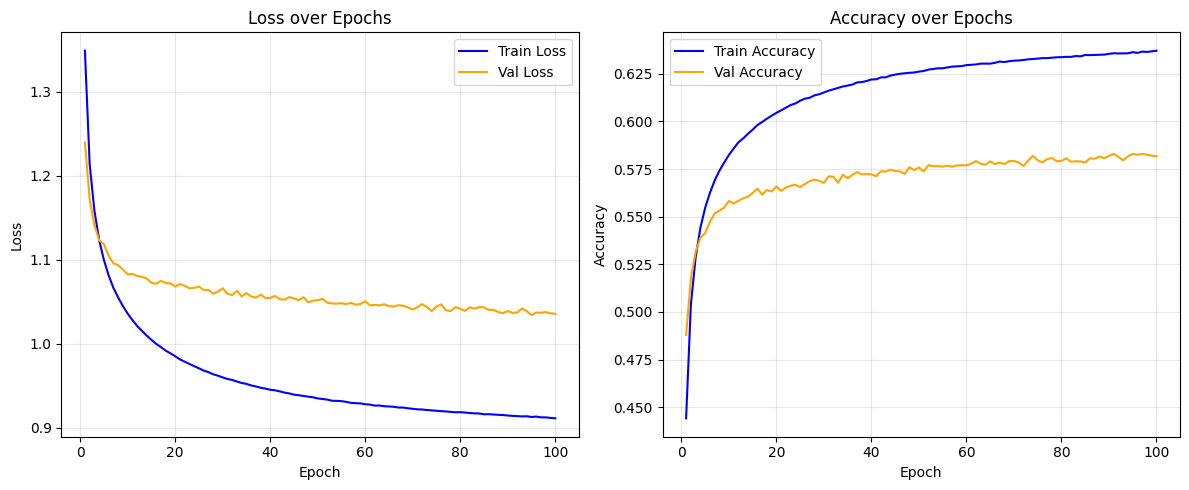

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
def vector_to_fen(vector):
    """
    Reconstructs a FEN string from the 775-dim bitboard vector.
    """

    index_to_piece = {
        0: 'P', 1: 'N', 2: 'B', 3: 'R', 4: 'Q', 5: 'K',
        6: 'p', 7: 'n', 8: 'b', 9: 'r', 10: 'q', 11: 'k'
    }
    
    board = chess.Board(None) 
    
    for piece_idx in range(12):
        for square in range(64):
            idx = piece_idx * 64 + square
            if vector[idx] == 1:
                piece = chess.Piece.from_symbol(index_to_piece[piece_idx])
                board.set_piece_at(square, piece)
                
    board.turn = chess.WHITE if vector[768] == 1 else chess.BLACK

    castling_fen = ""
    if vector[769] == 1: castling_fen += "K"
    if vector[770] == 1: castling_fen += "Q"
    if vector[771] == 1: castling_fen += "k"
    if vector[772] == 1: castling_fen += "q"
    if castling_fen == "": castling_fen = "-"
    
    board.set_castling_fen(castling_fen)
    
    return board.fen()

In [26]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def generate_saliency_map(model, input_tensor, target_class):
    """
    input_tensor: Shape (1, 19, 8, 8) or (1, 775)
    target_class: The class index (0-6) you want to explain (e.g., the WRONG prediction)
    """
    model.eval()
    
    # Enable Gradient Calculation for the Input 
    input_tensor.requires_grad_()
    
    # Forward Pass
    output = model(input_tensor)
    
    # Focus on the specific class score we want to explain
    # (e.g., "Why did you predict Class 0?")
    score = output[0, target_class]
    
    # Backward Pass (Calculate Gradients)
    score.backward()
    
    # Get the Gradients (Sensitivity)
    # Shape matches input. e.g. (1, 19, 8, 8)
    gradients = input_tensor.grad.data.abs()
    
    # Collapse Channels to get a single 8x8 Heatmap
    # For CNN (19, 8, 8) -> Take max across channels -> (8, 8)
    if len(gradients.shape) == 4:
        heatmap, _ = torch.max(gradients[0], dim=0)
    
    # For MLP (1, 775) -> Reshape first 768 bits to (12, 8, 8) then max
    else:
        # Extract just the board bits (0-768), ignore global bits
        board_bits = gradients[0, :768].view(12, 8, 8)
        heatmap, _ = torch.max(board_bits, dim=0)
        
    return heatmap

def plot_chess_heatmap(heatmap, fen_str):
    """Overlay the heatmap on a chess board"""
    heatmap = heatmap.numpy()
    
    plt.figure(figsize=(6, 6))
    
    # 'hot' colormap: White/Yellow = High Attention, Black/Red = Low Attention
    sns.heatmap(heatmap, cmap='hot', annot=False, cbar=True, square=True)
    
    plt.title(f"Model Attention Map\n{fen_str}")
    plt.gca().invert_yaxis() # Match chess board orientation (Rank 1 at bottom)
    plt.show()

Analyzing failure at dataset index: 46661
Reconstructed FEN: 5r2/4kb2/5Qp1/5pKp/5P2/7P/6P1/8 b - - 0 1
True Class Label: 0
Model Predicted: 6 (Error: 6 bins)


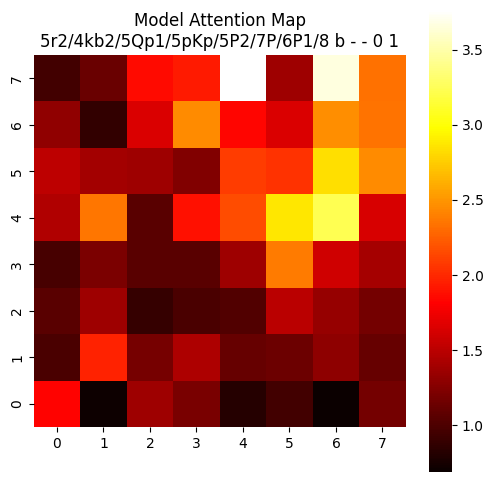

In [ ]:
from pathlib import Path
import json
import numpy as np
import chess
import torch
import torch.nn as nn

class PyramidalMLP_v2(nn.Module):
    def __init__(self, input_shape=775, output_shape=7):
        super().__init__()
        
        self.network = nn.Sequential(
            # Project up to capture complex feature interactions
            nn.Linear(input_shape, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(400, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        return self.network(x)

# Load Failure Indices
failure_path = Path(f"./experiments/results/{RUN_ID}_failure_indices.json")
with open(failure_path, 'r') as f:
    failures = json.load(f)

# Pick an index from the "3" bin (Errors off by 3 classes)
# --------------------------------------------------------------------------------------------------------------------------------------------------
target_error_bin = "6"
# --------------------------------------------------------------------------------------------------------------------------------------------------
if target_error_bin in failures and failures[target_error_bin]:
    target_idx = failures[target_error_bin][400] # Pick the first failed case
    print(f"Analyzing failure at dataset index: {target_idx}")
else:
    raise ValueError(f"No failures found for bin {target_error_bin}")

# Load the Dataset Row
data_path = TEST_PATH
data = np.load(data_path)

# Extract vector and label
input_vector = data['X'][target_idx] 
true_label = int(data['y'][target_idx])

# Reconstruct FEN
fen_str = vector_to_fen(input_vector)
print(f"Reconstructed FEN: {fen_str}")
print(f"True Class Label: {true_label}")

# Load Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = Path(f"{model_save_name}.pth")

model = PyramidalMLP_v2(input_shape=775, output_shape=7)
# Load weights (assuming state_dict was saved)
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
except:
    # Fallback if full model was saved instead of state_dict
    model = torch.load(model_path, map_location=device)

model.to(device)
model.eval()

# Generate Heatmap
input_tensor = torch.tensor(input_vector, dtype=torch.float32).unsqueeze(0).to(device)

# We usually want to explain the WRONG prediction (why did it pick that?) or the TRUE label (what did it miss?).
with torch.no_grad():
    logits = model(input_tensor)
    predicted_class = torch.argmax(logits, dim=1).item()

print(f"Model Predicted: {predicted_class} (Error: {abs(predicted_class - true_label)} bins)")

# Visualize attention for the PREDICTED (wrong) class
heatmap = generate_saliency_map(model, input_tensor, target_class=predicted_class)
plot_chess_heatmap(heatmap.cpu(), fen_str)

Black to move


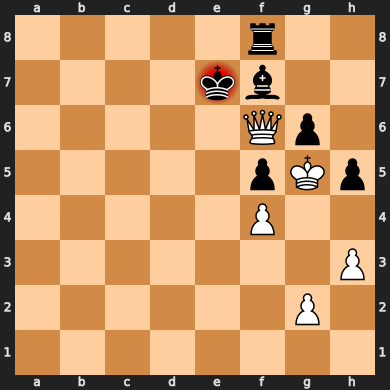

In [33]:
board = chess.Board(fen_str)
if board.turn == chess.WHITE:
    print("White to move")
else:
    print("Black to move")
board

Analyzing performance across Game Phases...


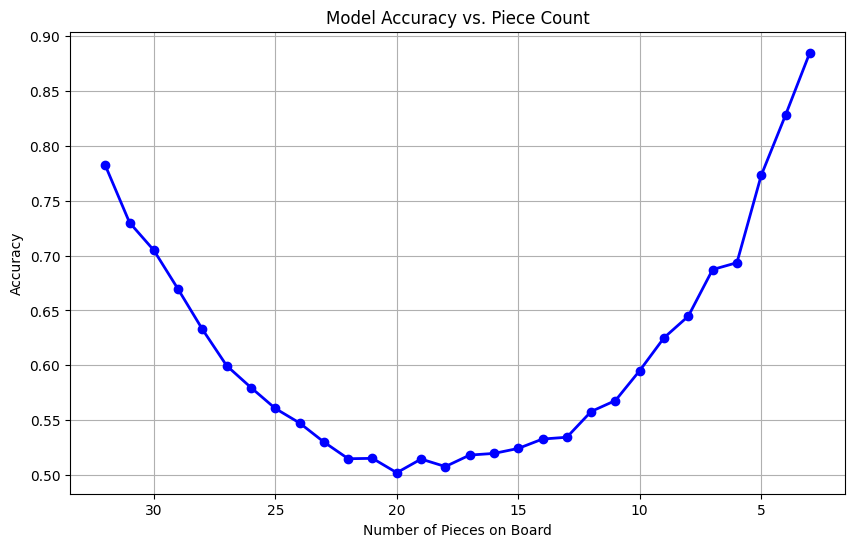

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_game_phase_performance(model, test_loader, device):
    model.eval()
    
    # Dictionary to store results: { piece_count: [correct_predictions, total_samples] }
    phase_stats = {i: [0, 0] for i in range(33)} # Max 32 pieces on board
    
    print("Analyzing performance across Game Phases...")
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            
            X_cpu = X.cpu().numpy()
            y_cpu = y.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(y_cpu)):
                # 1. Count Pieces (Sum of first 768 bits)
                # Note: This counts Kings too. 
                piece_count = int(np.sum(X_cpu[i, :768]))
                
                # 2. Record Correctness
                is_correct = 1 if preds_cpu[i] == y_cpu[i] else 0
                
                phase_stats[piece_count][0] += is_correct
                phase_stats[piece_count][1] += 1
                
    # --- PROCESS & PLOT ---
    
    counts = []
    accuracies = []
    
    # We aggregate slightly to avoid noise (e.g., group 3-5 pieces together)
    # But for a raw plot, let's just do Piece Count 3 to 32
    valid_piece_counts = sorted([k for k, v in phase_stats.items() if v[1] > 50]) # Filter rare counts
    
    for pc in valid_piece_counts:
        correct, total = phase_stats[pc]
        acc = correct / total
        counts.append(pc)
        accuracies.append(acc)
        
    # PLOT
    plt.figure(figsize=(10, 6))
    plt.plot(counts, accuracies, marker='o', linewidth=2, color='b')
    plt.title("Model Accuracy vs. Piece Count")
    plt.xlabel("Number of Pieces on Board")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.gca().invert_xaxis() # Standard Chess Style: Endgames (Low numbers) on the Right
    plt.show()
    
    return counts, accuracies

# Run it
counts, accs = analyze_game_phase_performance(model, test_dataloader, device)

Analyzing performance across Game Phases (0-24)...


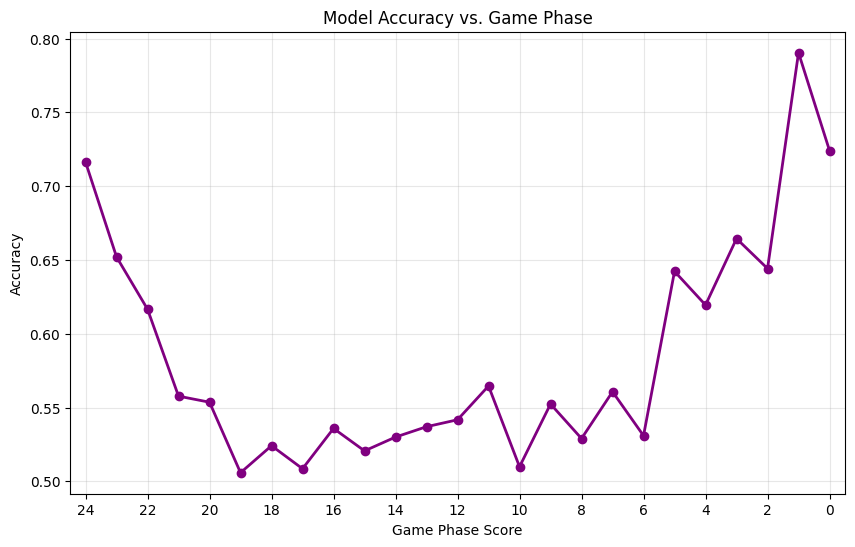

In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def analyze_phase_performance(model, test_loader, device):
    model.eval()
    
    # Dictionary to store results: { phase_score: [correct_predictions, total_samples] }
    # Phase scores range from 0 to 24
    phase_stats = {i: [0, 0] for i in range(25)} 
    
    print("Analyzing performance across Game Phases (0-24)...")
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            
            X_cpu = X.cpu().numpy()
            y_cpu = y.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            # Vectorized Phase Calculation for the whole batch (Faster)
            # 1. Knights (White + Black)
            n_count = np.sum(X_cpu[:, 64:128], axis=1) + np.sum(X_cpu[:, 448:512], axis=1)
            # 2. Bishops
            b_count = np.sum(X_cpu[:, 128:192], axis=1) + np.sum(X_cpu[:, 512:576], axis=1)
            # 3. Rooks
            r_count = np.sum(X_cpu[:, 192:256], axis=1) + np.sum(X_cpu[:, 576:640], axis=1)
            # 4. Queens
            q_count = np.sum(X_cpu[:, 256:320], axis=1) + np.sum(X_cpu[:, 640:704], axis=1)
            
            # Formula: N*1 + B*1 + R*2 + Q*4
            phases = (n_count * 1) + (b_count * 1) + (r_count * 2) + (q_count * 4)
            phases = np.minimum(phases, 24).astype(int)
            
            # Update Stats
            for i, phase in enumerate(phases):
                is_correct = 1 if preds_cpu[i] == y_cpu[i] else 0
                phase_stats[phase][0] += is_correct
                phase_stats[phase][1] += 1
                
    # --- PROCESS & PLOT ---
    counts = []
    accuracies = []
    
    # Filter valid phases (some deep endgames might have 0 samples)
    valid_phases = sorted([k for k, v in phase_stats.items() if v[1] > 20])
    
    for p in valid_phases:
        correct, total = phase_stats[p]
        acc = correct / total
        counts.append(p)
        accuracies.append(acc)
        
    # PLOT
    plt.figure(figsize=(10, 6))
    plt.plot(counts, accuracies, marker='o', linewidth=2, color='purple')
    
    plt.title("Model Accuracy vs. Game Phase")
    plt.xlabel("Game Phase Score")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    # Invert X axis: Start (24) -> End (0)
    plt.xlim(24.5, -0.5)
    plt.xticks(range(0, 25, 2))
    
    plt.show()
    
    return counts, accuracies

# Run it
counts, accs = analyze_phase_performance(model, test_dataloader, device)

Scanning for 'Positional Wins' (Equal Material, but Decisive Result)...
----------------------------------------
POSITIONAL UNDERSTANDING REPORT
----------------------------------------
Total Positions Analyzed: 200455
Model Accuracy:           58.60%
----------------------------------------
Breakdown of Errors:
  Total Errors:           82990
  Mistook for Draw:       19420 (23.4% of errors)
  Picked Wrong Winner:    63570
----------------------------------------


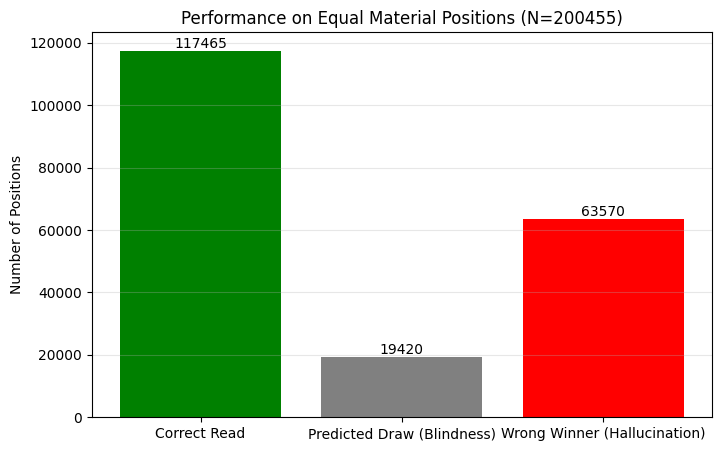

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def analyze_positional_understanding(model, test_loader, device):
    model.eval()
    
    # Counters
    total_material_equal_positions = 0
    correct_positional_reads = 0
    
    # We will also track what the model predicted wrongly (e.g. did it predict Draw?)
    confusion_counts = {"Predicted Draw": 0, "Predicted Wrong Winner": 0}
    
    print("Scanning for 'Positional Wins' (Equal Material, but Decisive Result)...")
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            
            X_cpu = X.cpu().numpy()
            y_cpu = y.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            # --- 1. CALCULATE MATERIAL FOR WHITE & BLACK ---
            # Indices: P=0, N=1, B=2, R=3, Q=4 (King ignored for material count)
            # Weights: Standard (1, 3, 3, 5, 9)
            
            # WHITE (Indices 0 - 320)
            w_pawns   = np.sum(X_cpu[:, 0:64], axis=1)
            w_knights = np.sum(X_cpu[:, 64:128], axis=1)
            w_bishops = np.sum(X_cpu[:, 128:192], axis=1)
            w_rooks   = np.sum(X_cpu[:, 192:256], axis=1)
            w_queens  = np.sum(X_cpu[:, 256:320], axis=1)
            
            w_score = (w_pawns * 1) + (w_knights * 3) + (w_bishops * 3) + (w_rooks * 5) + (w_queens * 9)

            # BLACK (Indices 384 - 704)
            b_pawns   = np.sum(X_cpu[:, 384:448], axis=1)
            b_knights = np.sum(X_cpu[:, 448:512], axis=1)
            b_bishops = np.sum(X_cpu[:, 512:576], axis=1)
            b_rooks   = np.sum(X_cpu[:, 576:640], axis=1)
            b_queens  = np.sum(X_cpu[:, 640:704], axis=1)
            
            b_score = (b_pawns * 1) + (b_knights * 3) + (b_bishops * 3) + (b_rooks * 5) + (b_queens * 9)
            
            # --- 2. FILTER: EQUAL MATERIAL ---
            is_equal_material = (w_score == b_score)
            
            # --- 3. FILTER: NOT A DRAW (Class != 3) ---
            # We want positions where stockfish says someone is winning
            is_decisive = (y_cpu != 3)
            
            # Combine filters
            target_indices = np.where(is_equal_material & is_decisive)[0]
            
            # --- 4. EVALUATE ---
            if len(target_indices) > 0:
                total_material_equal_positions += len(target_indices)
                
                relevant_preds = preds_cpu[target_indices]
                relevant_labels = y_cpu[target_indices]
                
                # Check accuracy
                matches = (relevant_preds == relevant_labels)
                correct_positional_reads += np.sum(matches)
                
                # Analyze errors
                errors = ~matches
                error_preds = relevant_preds[errors]
                
                # Count how many times it lazily predicted "Equal" (Class 3)
                confusion_counts["Predicted Draw"] += np.sum(error_preds == 3)
                confusion_counts["Predicted Wrong Winner"] += np.sum(error_preds != 3)

    # --- REPORTING ---
    if total_material_equal_positions == 0:
        print("No positions found with equal material but decisive results.")
        return
        
    accuracy = correct_positional_reads / total_material_equal_positions
    draw_bias = confusion_counts["Predicted Draw"] / (total_material_equal_positions - correct_positional_reads + 1e-9)

    print("-" * 40)
    print(f"POSITIONAL UNDERSTANDING REPORT")
    print("-" * 40)
    print(f"Total Positions Analyzed: {total_material_equal_positions}")
    print(f"Model Accuracy:           {accuracy:.2%}")
    print("-" * 40)
    print("Breakdown of Errors:")
    print(f"  Total Errors:           {total_material_equal_positions - correct_positional_reads}")
    print(f"  Mistook for Draw:       {confusion_counts['Predicted Draw']} ({draw_bias:.1%} of errors)")
    print(f"  Picked Wrong Winner:    {confusion_counts['Predicted Wrong Winner']}")
    print("-" * 40)

    # Simple Bar Plot
    plt.figure(figsize=(8, 5))
    categories = ['Correct Read', 'Predicted Draw (Blindness)', 'Wrong Winner (Hallucination)']
    values = [correct_positional_reads, confusion_counts['Predicted Draw'], confusion_counts['Predicted Wrong Winner']]
    
    bars = plt.bar(categories, values, color=['green', 'gray', 'red'])
    plt.title(f"Performance on Equal Material Positions (N={total_material_equal_positions})")
    plt.ylabel("Number of Positions")
    plt.grid(axis='y', alpha=0.3)
    
    # Add counts on top
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')
        
    plt.show()

# Run it
analyze_positional_understanding(model, test_dataloader, device)